# Setup

In [1]:
import numpy as np
from agents_clean import Agent
from model_clean import Model
from hybrid_networks_clean import rewire_network, randomize_network_v2, create_hybrid_network, densify_network
from tqdm import tqdm
import networkx as nx
import pandas as pd
import random
from datetime import datetime
import itertools
import numbers
#import opinionated
import matplotlib.pyplot as plt
#plt.style.use("opinionated_rc")
#import colormaps as cmaps  

# Load Networks

In [2]:
!pip install dill
import dill

# Use dill to deserialize the graph from a file
with open('data_proc/perceptron_graph_pre_1979.pkl', 'rb') as f:
    G_perceptron = dill.load(f)

# Create a mapping from node names to indexes
mapping = {node: index for index, node in enumerate(G_perceptron.nodes())}

# Relabel the nodes in the graph
G_perceptron_indexed = nx.relabel_nodes(G_perceptron, mapping)
print('\n')
print(G_perceptron_indexed.nodes(data=True)[0])
print('\n')

# # Use dill to deserialize the graph from a file
with open('data_proc/peptic_ulcer_graph_pre_1978.pkl', 'rb') as f:
     G_pepticulcer = dill.load(f)

# # Create a mapping from node names to indexes
mapping = {node: index for index, node in enumerate(G_pepticulcer.nodes())}

# # Relabel the nodes in the graph
G_pepticulcer_indexed = nx.relabel_nodes(G_pepticulcer, mapping)
print('\n')
print(G_pepticulcer_indexed.nodes(data=True)[0])
print('\n')


[notice] A new release of pip is available: 23.3.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


{'authored_paper_count': 6, 'cited_count': 124, 'titles': ['The perceptron: A probabilistic model for information storage and organization in the brain.', 'PRINCIPLES OF NEURODYNAMICS. PERCEPTRONS AND THE THEORY OF BRAIN MECHANISMS', 'Analysis of a Four-Layer Series-Coupled Perceptron. II', 'The perceptron: A probabilistic model for information storage and organization in the brain.', 'Perceptron Simulation Experiments', 'PRINCIPLES OF NEURODYNAMICS. PERCEPTRONS AND THE THEORY OF BRAIN MECHANISMS', 'Perceptron Simulation Experiments', 'The perceptron: A probabilistic model for information storage and organization in the brain.', 'PRINCIPLES OF NEURODYNAMICS. PERCEPTRONS AND THE THEORY OF BRAIN MECHANISMS', 'PRINCIPLES OF NEURODYNAMICS. PERCEPTRONS AND THE THEORY OF BRAIN MECHANISMS', 'Analysis of a Four-Layer Series-Coupled Perceptron. II', 'PRINCIPLES OF NEURODYNAMICS. PE

# Setting Up the Functions

## Generate Parameters

In [4]:
def generate_parameters_empir(n,G,rewiring_type='randomize'):
    params_list = []
    #print('Generating parameters...')
    for _ in tqdm(range(n),desc="Generating parameters"):
        #n_agents = random.randint(10, 500)
        n_agents = len(G.nodes())
        #ba_degree = random.randint(1, int(n_agents/10))
        #er_prob=random.uniform(0, 0.3)
        p_rewiring = random.uniform(0, 1)
        if rewiring_type=='hierarchical':
            #G_er = nx.gnp_random_graph(n_agents, er_prob, directed=True)
            network = rewire_network(G, p_rewiring=p_rewiring)
        if rewiring_type=='randomize':
            #G_ba = nx.barabasi_albert_graph(n_agents, ba_degree)
            network = randomize_network_v2(G, p_rewiring=p_rewiring)
        # Calculate the mean degree of each node
        degrees = dict(network.degree())
        mean_degree = sum(degrees.values()) / len(degrees)
        uncertainty = random.uniform(0.001,0.025)
        n_experiments = random.randint(10, 10000)
        params = {
            "n_agents": n_agents,
            #"ba_degree": ba_degree,
            #"er_prob":er_prob,
            "p_rewiring": p_rewiring,
            "network": network,
            "uncertainty": uncertainty,
            "n_experiments": n_experiments,
            "rewiring_type":rewiring_type,
            'mean_degree':mean_degree
        }
        params_list.append(params)
    return params_list

In [5]:
# Example usage
parameter_dictionaries = generate_parameters_empir(2,G_perceptron_indexed,
                                                   rewiring_type='randomize')  # Generate parameter dictionaries
parameter_dictionaries

Generating parameters:   0%|          | 0/2 [00:00<?, ?it/s]

Generating parameters: 100%|██████████| 2/2 [00:00<00:00, 16.65it/s]


[{'n_agents': 3519,
  'p_rewiring': 0.13202388683043131,
  'network': <networkx.classes.digraph.DiGraph at 0x7fb7d6ff8460>,
  'uncertainty': 0.008122801637547961,
  'n_experiments': 3038,
  'rewiring_type': 'randomize',
  'mean_degree': 4.346689400397841},
 {'n_agents': 3519,
  'p_rewiring': 0.698797589484808,
  'network': <networkx.classes.digraph.DiGraph at 0x7fb7d6ffb220>,
  'uncertainty': 0.02090143624711605,
  'n_experiments': 8662,
  'rewiring_type': 'randomize',
  'mean_degree': 4.346689400397841}]

## Simulation Functions

In [6]:
def run_simulation_with_params(param_dict, number_of_steps=10000, agent_type="bayes",tolerance=1e-03):
    # Extract the network directly since it's already a NetworkX graph object
    my_network = param_dict['network']
    #agent_type = param_dict['agent_type']
    # Other parameters are directly extracted from the dictionary
    my_model = Model(my_network, n_experiments=param_dict['n_experiments'], uncertainty=param_dict['uncertainty']
                    , agent_type=agent_type,tolerance=tolerance)
    # Run the simulation with predefined steps and show_bar option
    
    my_model.run_simulation(number_of_steps=number_of_steps, show_bar=False)
  
    

    result_dict = {
        key: value 
        for key, value in param_dict.items() 
        if isinstance(value, (numbers.Number, str, tuple, list))}   
    result_dict['true_consensus'] = my_model.conclusion
    #result_dict['true_consensus_alternative_stop'] = my_model.conclusion_alternative_stop
    #df = pd.DataFrame(my_model.agents_choices) 
    #result_dict['choice_consensus'] = df.mean()[len(df.mean())-1]
    result_dict['convergence_step'] = my_model.n_steps # takes note of the last reported step
    result_dict['agent_type']=agent_type
    #result_dict['n_experiments']=param_dict['n_experiments']
    
    return result_dict


def run_simulations(param_list, number_of_steps=10000,agent_type="bayes",tolerance=1e-03):
    def run_simulation(param_dict,tolerance=tolerance):
        return run_simulation_with_params(param_dict, number_of_steps=number_of_steps, agent_type=agent_type)
    
    results = []
    # Iterate over each parameter dictionary in the list
    for params in tqdm(param_list, desc="Running simulations"):
        result = run_simulation(params)
        results.append(result)
    
    # Convert the list of results into a Pandas DataFrame
    results_df = pd.DataFrame(results)
    return results_df

In [7]:
# Test Simulation
parameter_dictionaries = generate_parameters_empir(1,G_perceptron_indexed,
                                                   rewiring_type='randomize')  # Generate parameter dictionaries
#print(parameter_dictionaries)
test_results_df = run_simulations(parameter_dictionaries, number_of_steps=10000, 
                                  agent_type="bayes",tolerance=1e-02)
test_results_df.to_csv('test_results_df.csv', index=False)
test_results_df.head()

Generating parameters:   0%|          | 0/1 [00:00<?, ?it/s]

Running simulations: 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


,n_agents,p_rewiring,uncertainty,n_experiments,rewiring_type,mean_degree,true_consensus,convergence_step,agent_type
0,3519,0.257687,0.020836,9263,randomize,4.346121,0.705882,8,bayes


## Plotting Functions

In [7]:
def plot_results(results_df=test_results_df,variable_of_interest = 'true_consensus',regressor = 'n_agents'):
    grouped = results_df.groupby(['rewiring_type', regressor])[variable_of_interest].mean().reset_index()

    # Preparing for the line plot
    #grouped['mid_bin'] = grouped['binned'].apply(lambda x: x.mid).astype(float)  # Getting the midpoint of bins for plotting

    # Plotting
    plt.figure(figsize=(10, 8))

    for rewiring_type in results_df['rewiring_type'].unique():
        subset = grouped[grouped['rewiring_type'] == rewiring_type]
        plt.plot(subset[regressor], subset[variable_of_interest], marker='o', label=rewiring_type)

    plt.xlabel(regressor)
    plt.ylabel('Share of '+variable_of_interest)
    plt.title('Share of '+ variable_of_interest +' by ' + regressor)
    opinionated.add_legend(title='rewiring_type')

    plt.grid(True)
    plt.show()

In [8]:
def plot_loglog(G,m=1):
    degree_freq = nx.degree_histogram(G)
    degrees = range(len(degree_freq))
    plt.figure(figsize=(12, 8))
    plt.loglog(degrees[m:], degree_freq[m:],'go-')
    plt.xlabel('Degree')
    plt.ylabel('Frequency')

# Perceptron

Nodes in the network:
3519
Edges in the network:
7648


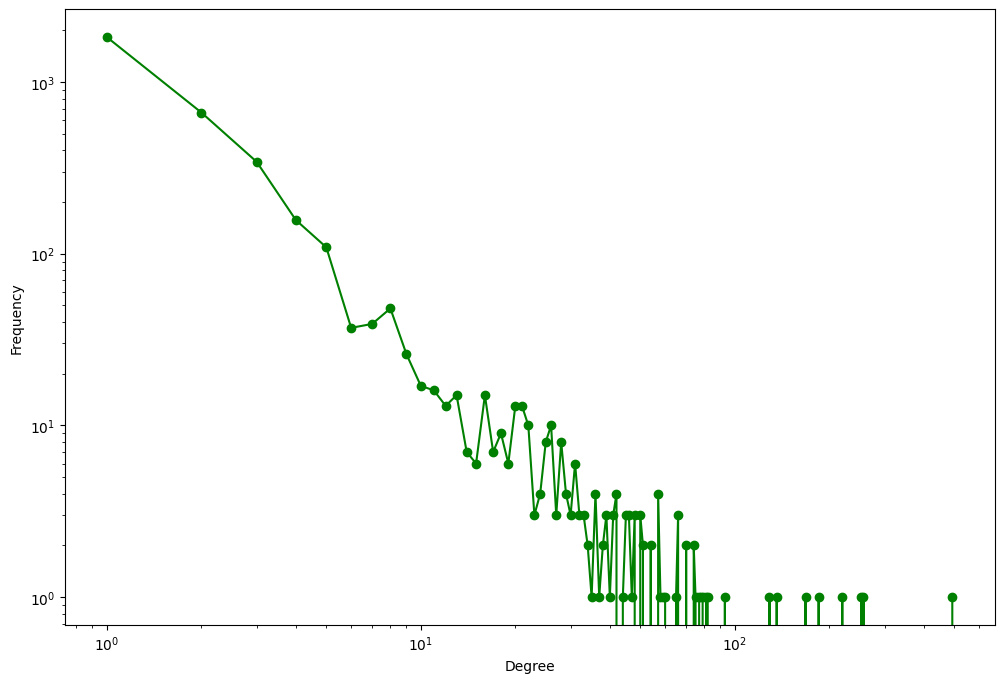

In [18]:
print("Nodes in the network:")
print(len(G_perceptron_indexed.nodes()))
# print("Edges in the network:")
# print(len(G.edges()))
#G_perceptron_indexed.nodes(data=True)
print("Edges in the network:")
print(len(G_perceptron_indexed.edges()))

plot_loglog(G_perceptron_indexed, m=1)

## Run Perceptron Simulations

In [58]:
# Bayes Agent
do_initial_simulation = False
if do_initial_simulation:
    n_sims = 10 # this is for each type of rewiring
    bayes_results_df = pd.DataFrame(columns=test_results_df.columns)
    for rewiring_type in ['randomize']:
        parameter_dictionaries = generate_parameters_empir(n_sims,G_perceptron_indexed,rewiring_type=rewiring_type)  # Generate parameter dictionaries
        results_df1 = run_simulations(parameter_dictionaries, number_of_steps=10000, 
                                  agent_type="bayes",tolerance=1e-03)
        bayes_results_df = pd.concat([bayes_results_df, results_df1], ignore_index=True)
        
    bayes_results_df.to_csv('bayesagent_perceptron_results_df.csv', index=False)

saved_bayes_results_df = pd.read_csv('bayesagent_perceptron_results_df.csv')

add_simulations = False
if add_simulations:
    n_sims = 1500 # this is for each type of rewiring
    bayes_results_df = pd.DataFrame(columns=test_results_df.columns)
    for rewiring_type in ['randomize']:
        parameter_dictionaries = generate_parameters_empir(n_sims,G_perceptron_indexed,rewiring_type=rewiring_type)  # Generate parameter dictionaries
        results_df1 = run_simulations(parameter_dictionaries, number_of_steps=10000, 
                                  agent_type="bayes",tolerance=1e-03)
        bayes_results_df = pd.concat([bayes_results_df, results_df1], ignore_index=True)
    bayes_results_df = pd.concat([saved_bayes_results_df, bayes_results_df], ignore_index=True)
    bayes_results_df.to_csv('bayesagent_perceptron_results_df.csv', index=False)
else: 
    bayes_results_df=saved_bayes_results_df

print(datetime.now())
    
bayes_results_df.info()

2024-06-17 18:05:42.186919
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   n_agents          2000 non-null   int64  
 1   p_rewiring        2000 non-null   float64
 2   uncertainty       2000 non-null   float64
 3   n_experiments     2000 non-null   int64  
 4   rewiring_type     2000 non-null   object 
 5   mean_degree       2000 non-null   float64
 6   true_consensus    2000 non-null   float64
 7   convergence_step  2000 non-null   int64  
 8   agent_type        2000 non-null   object 
dtypes: float64(4), int64(3), object(2)
memory usage: 140.8+ KB


In [57]:
# Beta Agent
do_initial_simulation = False
if do_initial_simulation:
    n_sims = 1
    beta_results_df = pd.DataFrame(columns=test_results_df.columns)
    for rewiring_type in ['randomize']:
        parameter_dictionaries = generate_parameters_empir(n_sims,G_perceptron_indexed,rewiring_type=rewiring_type)  # Generate parameter dictionaries
        results_df1 = run_simulations(parameter_dictionaries, number_of_steps=10000, 
                                  agent_type="beta",tolerance=1e-02)
        beta_results_df = pd.concat([beta_results_df, results_df1], ignore_index=True)
        
    beta_results_df.to_csv('betaagent_perceptron_results_df.csv', index=False)

saved_beta_results_df = pd.read_csv('betaagent_perceptron_results_df.csv')

add_simulations = False
total_beta_results_df = pd.DataFrame(columns=saved_beta_results_df.columns)
if add_simulations:
    beta_results_df = pd.DataFrame(columns=saved_beta_results_df.columns)
    for l in [100,100,100,100]:
        n_sims = l# this is for each type of rewiring
        parameter_dictionaries = generate_parameters_empir(n_sims,G_perceptron_indexed,
                                                           rewiring_type='randomize')  # Generate parameter dictionaries
        results_df1 = run_simulations(parameter_dictionaries, number_of_steps=10000, 
                                agent_type="beta",tolerance=1e-02)
        beta_results_df = pd.concat([beta_results_df, results_df1], ignore_index=True)
            
        total_beta_results_df = pd.concat([saved_beta_results_df, beta_results_df], ignore_index=True)
        total_beta_results_df.to_csv('betaagent_perceptron_results_df.csv', index=False)
else:
    beta_results_df = saved_beta_results_df
    
print(datetime.now())

beta_results_df.info()

2024-06-17 18:05:22.778230
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   n_agents          500 non-null    int64  
 1   p_rewiring        500 non-null    float64
 2   uncertainty       500 non-null    float64
 3   n_experiments     500 non-null    int64  
 4   rewiring_type     500 non-null    object 
 5   mean_degree       500 non-null    float64
 6   true_consensus    500 non-null    float64
 7   convergence_step  500 non-null    int64  
 8   agent_type        500 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 35.3+ KB


## Now Some Plotting

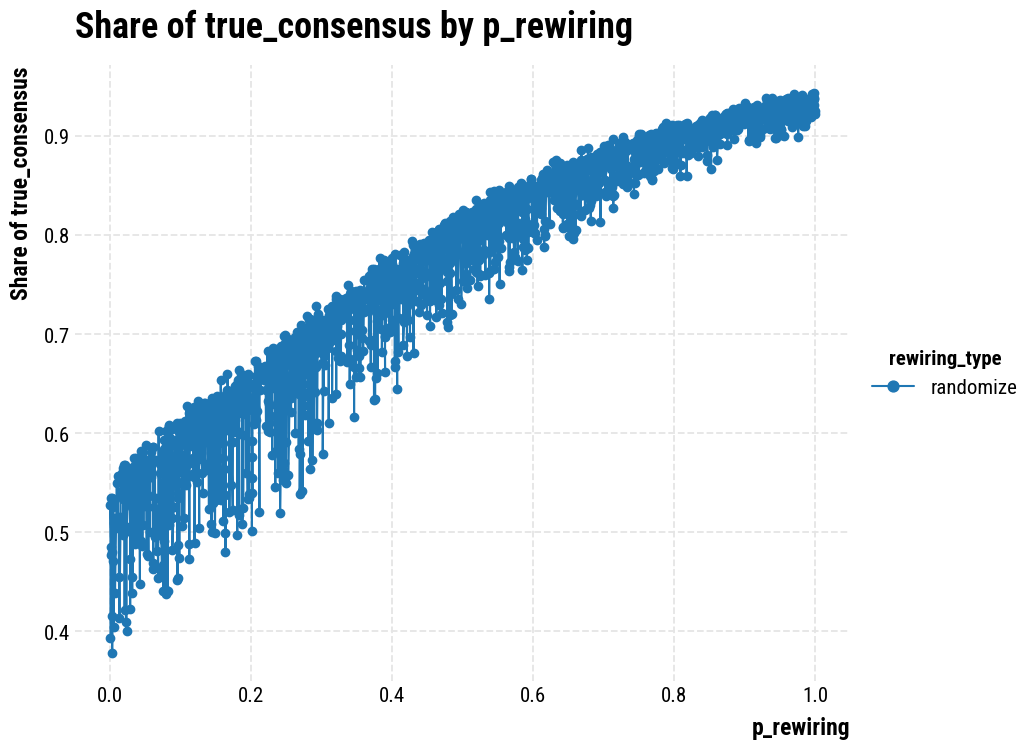

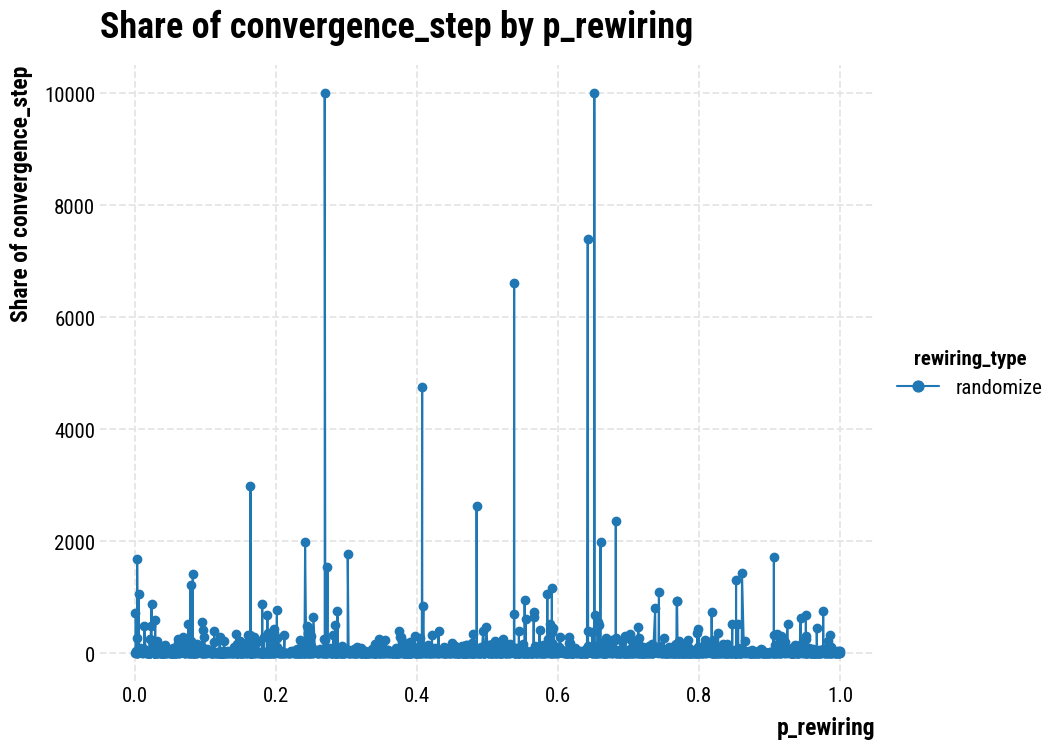

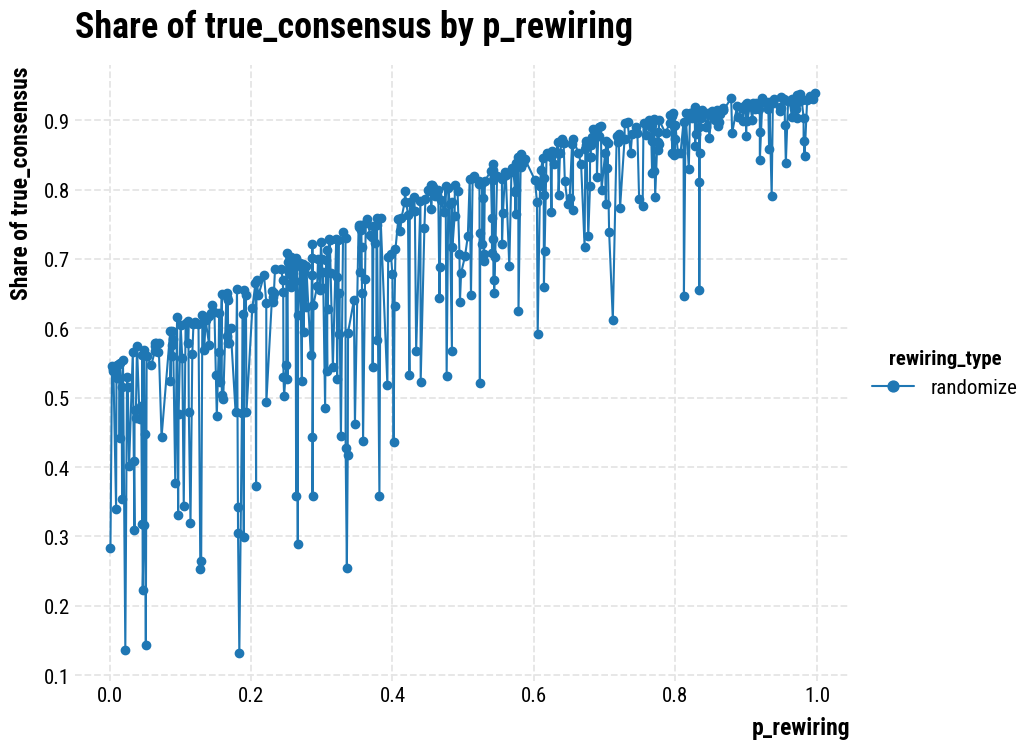

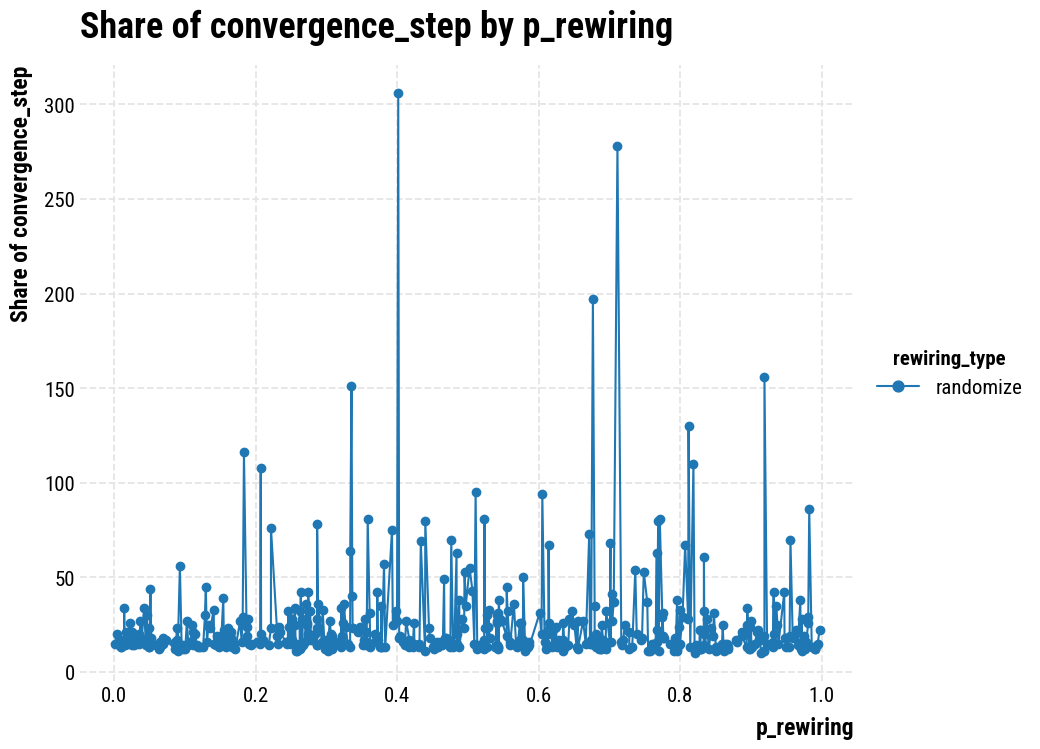

In [59]:
plot_results(bayes_results_df,variable_of_interest = 'true_consensus',regressor = 'p_rewiring')
plot_results(bayes_results_df,variable_of_interest = 'convergence_step',regressor = 'p_rewiring')
plot_results(beta_results_df,variable_of_interest = 'true_consensus',regressor = 'p_rewiring')
plot_results(beta_results_df,variable_of_interest = 'convergence_step',regressor = 'p_rewiring')

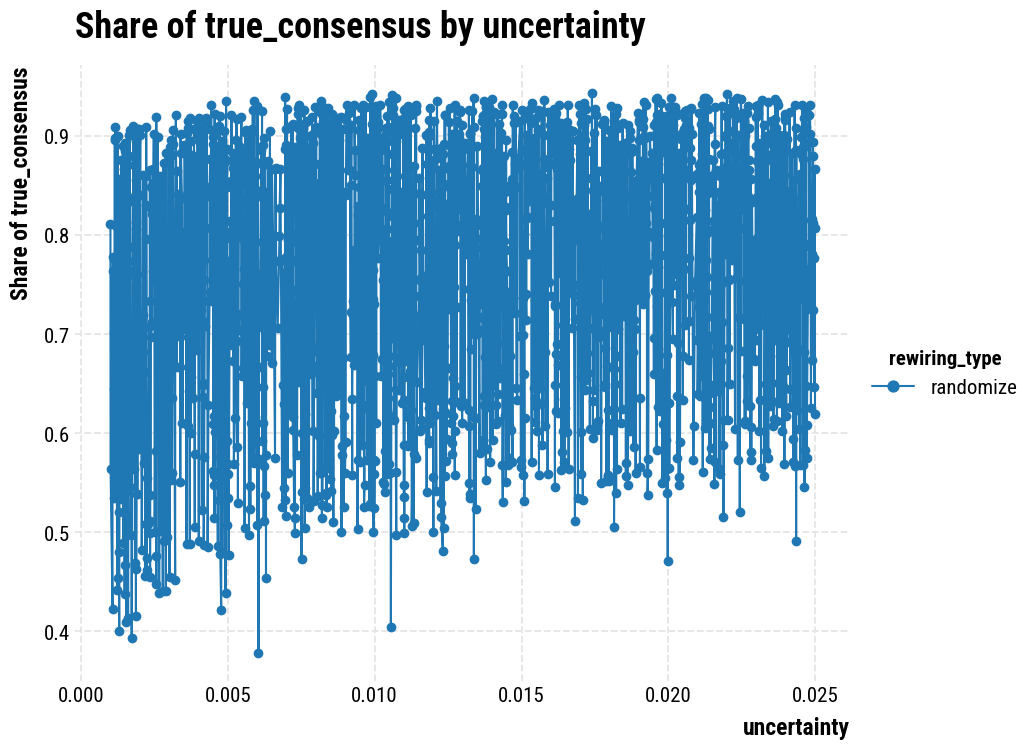

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


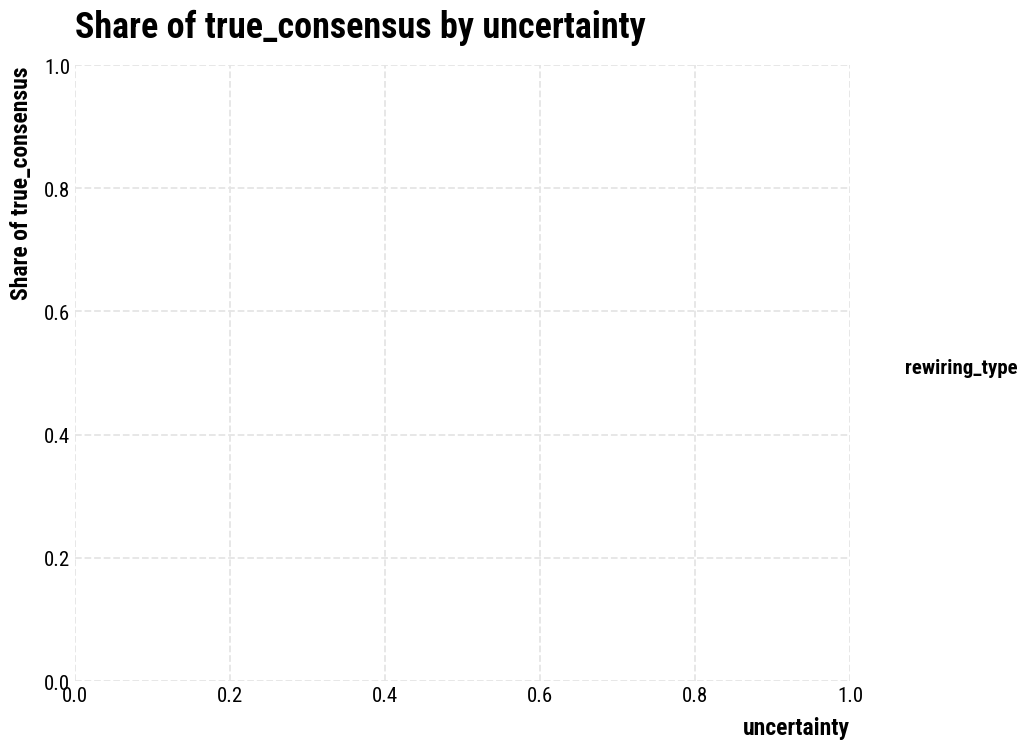

In [62]:
plot_results(bayes_results_df,variable_of_interest = 'true_consensus',regressor = 'uncertainty')
#plot_results(bayes_results_df,variable_of_interest = 'convergence_step',regressor = 'convergence_step')
plot_results(beta_results_df,variable_of_interest = 'true_consensus',regressor = 'uncertainty')
#plot_results(beta_results_df,variable_of_interest = 'convergence_step',regressor = 'convergence_step')

# Peptic Ulcer

Nodes in the network:
133403
Edges in the network:
785053


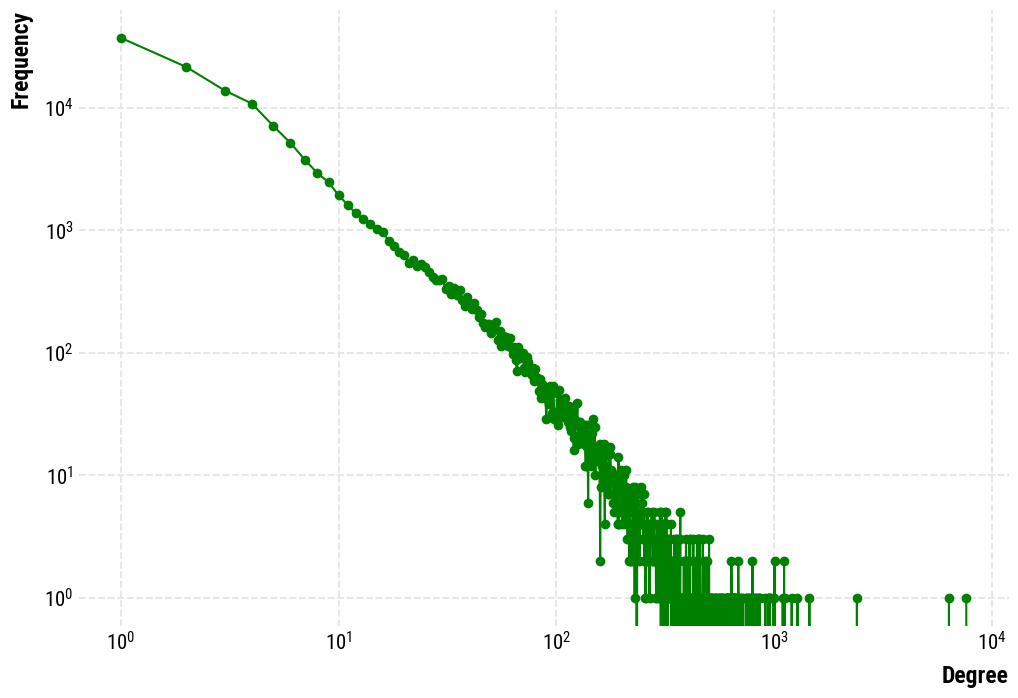

In [10]:
# # Use dill to deserialize the graph from a file
with open('data_proc/peptic_ulcer_graph_pre_1978.pkl', 'rb') as f:
     G_pepticulcer = dill.load(f)

# # Create a mapping from node names to indexes
mapping = {node: index for index, node in enumerate(G_pepticulcer.nodes())}

# # Relabel the nodes in the graph
G_pepticulcer_indexed = nx.relabel_nodes(G_pepticulcer, mapping)

print("Nodes in the network:")
print(len(G_pepticulcer_indexed.nodes()))
# print("Edges in the network:")
# print(len(G.edges()))
#G_pepticulcer_indexed.nodes(data=True)
print("Edges in the network:")
print(len(G_pepticulcer_indexed.edges()))

plot_loglog(G_pepticulcer_indexed,m=1)

In [12]:
# Test Simulation
parameter_dictionaries = generate_parameters_empir(1,G_pepticulcer_indexed,rewiring_type='randomize')  # Generate parameter dictionaries
#print(parameter_dictionaries)
test_results_df = run_simulations(parameter_dictionaries, number_of_steps=10000, agent_type="bayes")
test_results_df.to_csv('test_results_df.csv', index=False)
test_results_df.head()

Generating parameters:   0%|          | 0/1 [00:00<?, ?it/s]

Running simulations: 100%|██████████| 1/1 [00:17<00:00, 17.82s/it]


,n_agents,p_rewiring,uncertainty,n_experiments,rewiring_type,mean_degree,true_consensus,convergence_step,agent_type
0,133403,0.682294,0.009325,7738,randomize,11.7696,0.991799,9,bayes


## Run Peptic Ulcer Simulations (only randomization, only bayes, but full network)

In [29]:
# Bayes Agent
do_initial_simulation = False
if do_initial_simulation:
    n_sims = 1 # this is for each type of rewiring
    bayes_results_df = pd.DataFrame(columns=test_results_df.columns)
    for rewiring_type in ['randomize']:
        parameter_dictionaries = generate_parameters_empir(n_sims,G_pepticulcer_indexed,rewiring_type=rewiring_type)  # Generate parameter dictionaries
        results_df1 = run_simulations(parameter_dictionaries, number_of_steps=10000, 
                                  agent_type="bayes",tolerance=1e-02)
        bayes_results_df = pd.concat([bayes_results_df, results_df1], ignore_index=True)
        
    bayes_results_df.to_csv('bayesagent_pepticulcer_results_df.csv', index=False)

saved_bayes_results_df = pd.read_csv('bayesagent_pepticulcer_results_df.csv')

add_simulations = False
if add_simulations:
    n_sims = 100 # this is for each type of rewiring
    bayes_results_df = pd.DataFrame(columns=test_results_df.columns)
    for rewiring_type in ['randomize']:
        parameter_dictionaries = generate_parameters_empir(n_sims,G_pepticulcer_indexed,rewiring_type=rewiring_type)  # Generate parameter dictionaries
        results_df1 = run_simulations(parameter_dictionaries, number_of_steps=10000, 
                                  agent_type="bayes",tolerance=1e-02)
        bayes_results_df = pd.concat([bayes_results_df, results_df1], ignore_index=True)
    bayes_results_df = pd.concat([saved_bayes_results_df, bayes_results_df], ignore_index=True)
    bayes_results_df.to_csv('bayesagent_pepticulcer_results_df.csv', index=False)
else: 
    bayes_results_df=saved_bayes_results_df
  
bayes_results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   n_agents          500 non-null    int64  
 1   p_rewiring        500 non-null    float64
 2   uncertainty       500 non-null    float64
 3   n_experiments     500 non-null    int64  
 4   rewiring_type     500 non-null    object 
 5   mean_degree       500 non-null    float64
 6   true_consensus    500 non-null    float64
 7   convergence_step  500 non-null    int64  
 8   agent_type        500 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 35.3+ KB


In [73]:
# Beta Agent
do_initial_simulation = False
if do_initial_simulation:
    n_sims = 1
    beta_results_df = pd.DataFrame(columns=test_results_df.columns)
    for rewiring_type in ['randomize']:
        parameter_dictionaries = generate_parameters_empir(n_sims,G_pepticulcer_indexed,rewiring_type=rewiring_type)  # Generate parameter dictionaries
        results_df1 = run_simulations(parameter_dictionaries, number_of_steps=5000, 
                                  agent_type="beta",tolerance=1e-02)
        beta_results_df = pd.concat([beta_results_df, results_df1], ignore_index=True)
        
    beta_results_df.to_csv('betaagent_pepticulcer_results_df.csv', index=False)

saved_beta_results_df = pd.read_csv('betaagent_pepticulcer_results_df.csv')

add_simulations = False
total_beta_results_df = pd.DataFrame(columns=saved_beta_results_df.columns)
if add_simulations:
    beta_results_df = pd.DataFrame(columns=saved_beta_results_df.columns)
    for l in [50,50,50,50]:
        n_sims = l# this is for each type of rewiring
        parameter_dictionaries = generate_parameters_empir(n_sims,G_pepticulcer_indexed,
                                                           rewiring_type='randomize')  # Generate parameter dictionaries
        results_df1 = run_simulations(parameter_dictionaries, number_of_steps=5000, 
                                agent_type="beta",tolerance=1e-02)
        beta_results_df = pd.concat([beta_results_df, results_df1], ignore_index=True)
            
        total_beta_results_df = pd.concat([saved_beta_results_df, beta_results_df], ignore_index=True)
        total_beta_results_df.to_csv('betaagent_pepticulcer_results_df.csv', index=False)
else:
    beta_results_df = saved_beta_results_df
    
print(datetime.now())

beta_results_df.info()

2024-06-23 12:36:15.984540
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   n_agents          500 non-null    int64  
 1   p_rewiring        500 non-null    float64
 2   uncertainty       500 non-null    float64
 3   n_experiments     500 non-null    int64  
 4   rewiring_type     500 non-null    object 
 5   mean_degree       500 non-null    float64
 6   true_consensus    500 non-null    float64
 7   convergence_step  500 non-null    int64  
 8   agent_type        500 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 35.3+ KB


## Now Some Plotting

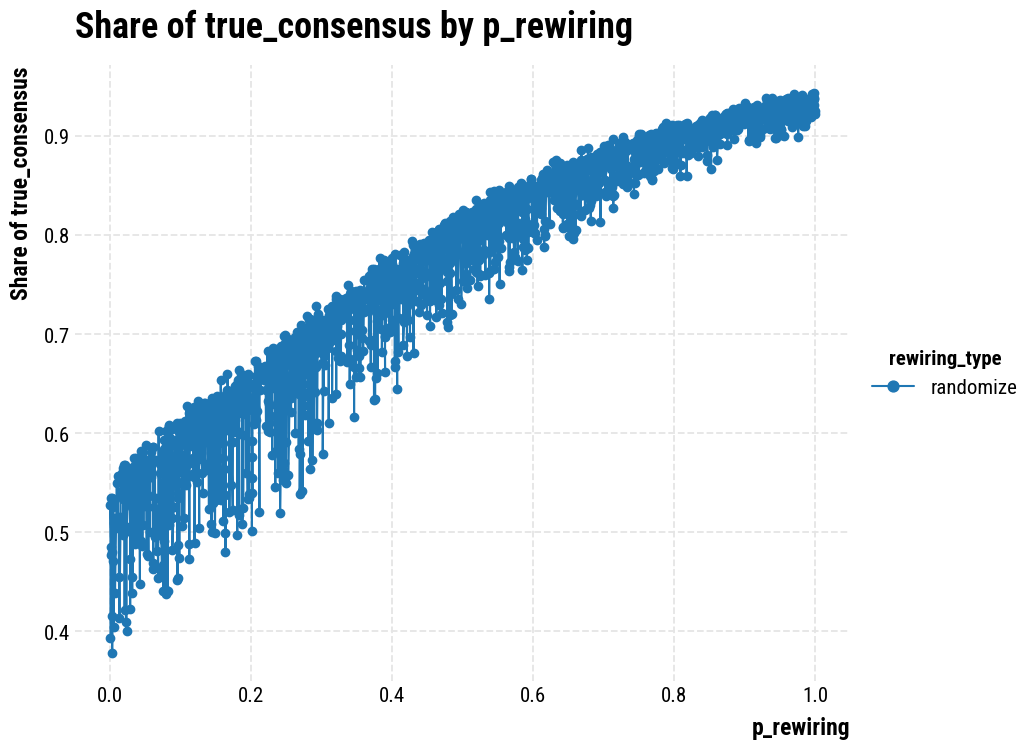

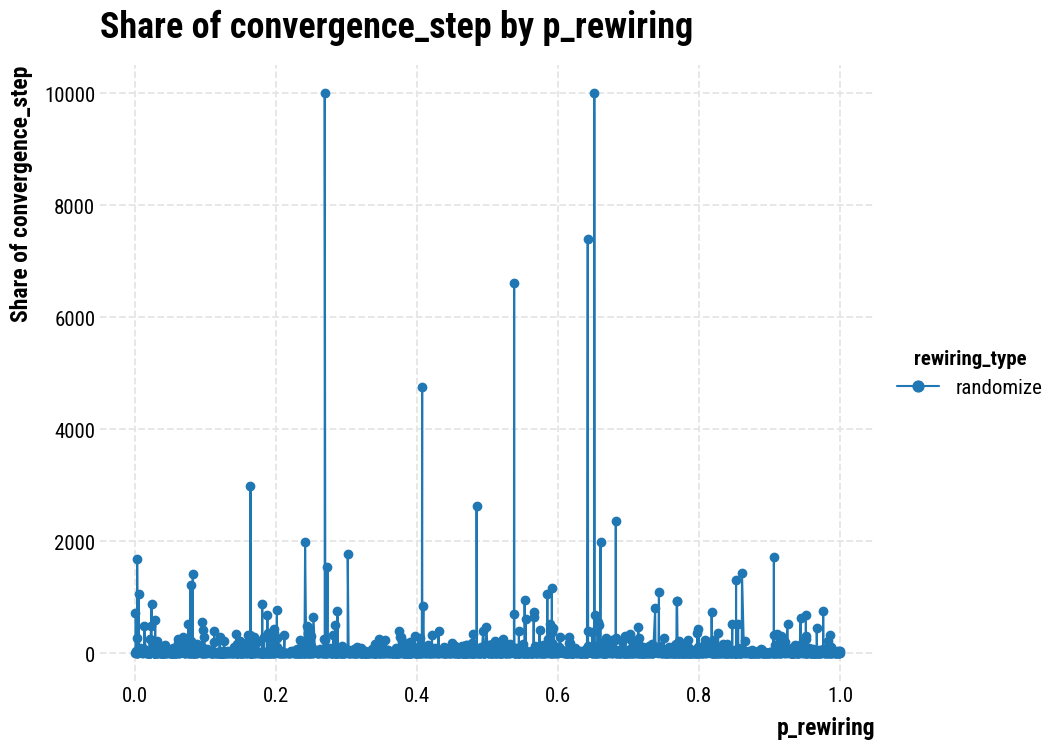

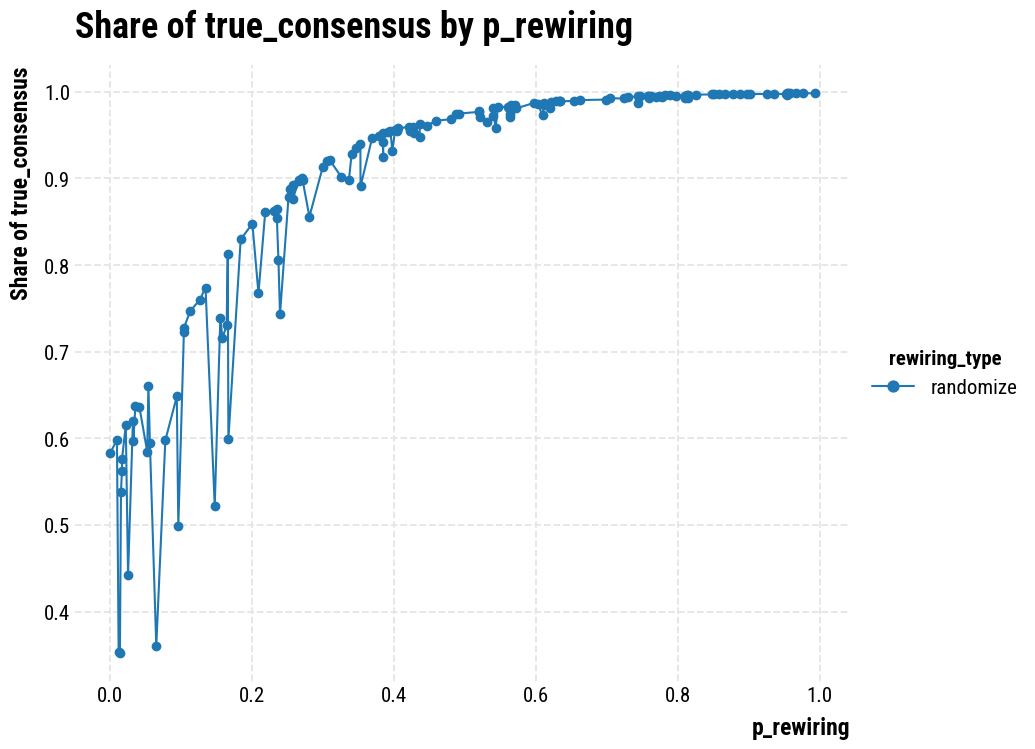

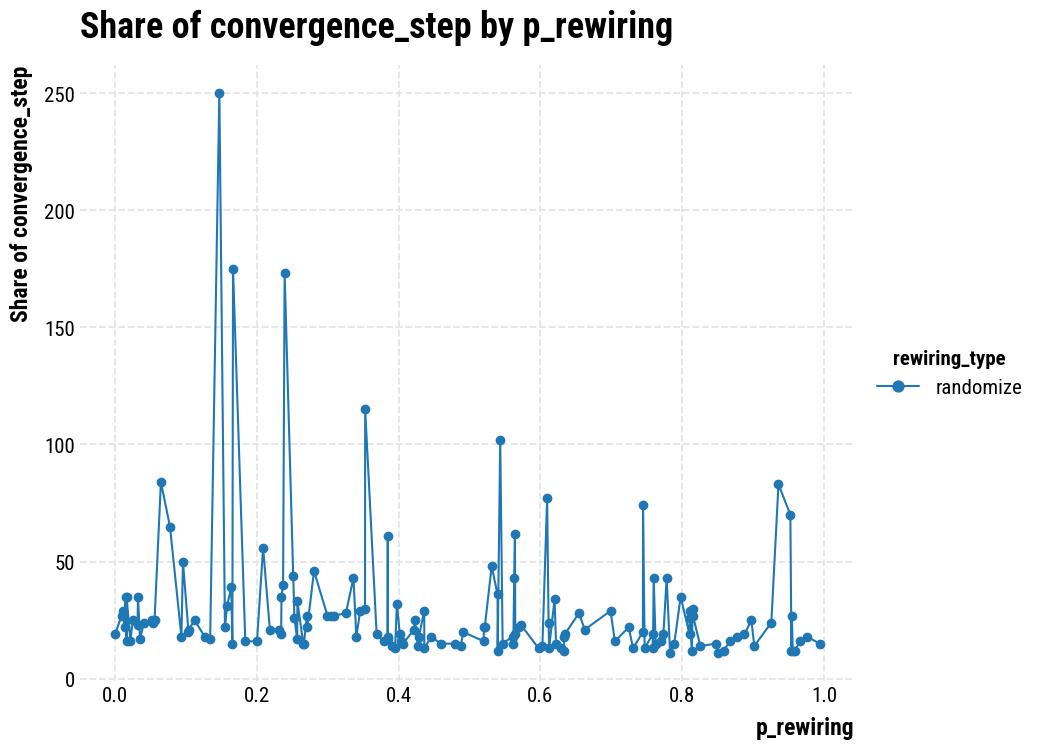

In [68]:
plot_results(bayes_results_df,variable_of_interest = 'true_consensus',regressor = 'p_rewiring')
plot_results(bayes_results_df,variable_of_interest = 'convergence_step',regressor = 'p_rewiring')
plot_results(beta_results_df,variable_of_interest = 'true_consensus',regressor = 'p_rewiring')
plot_results(beta_results_df,variable_of_interest = 'convergence_step',regressor = 'p_rewiring')

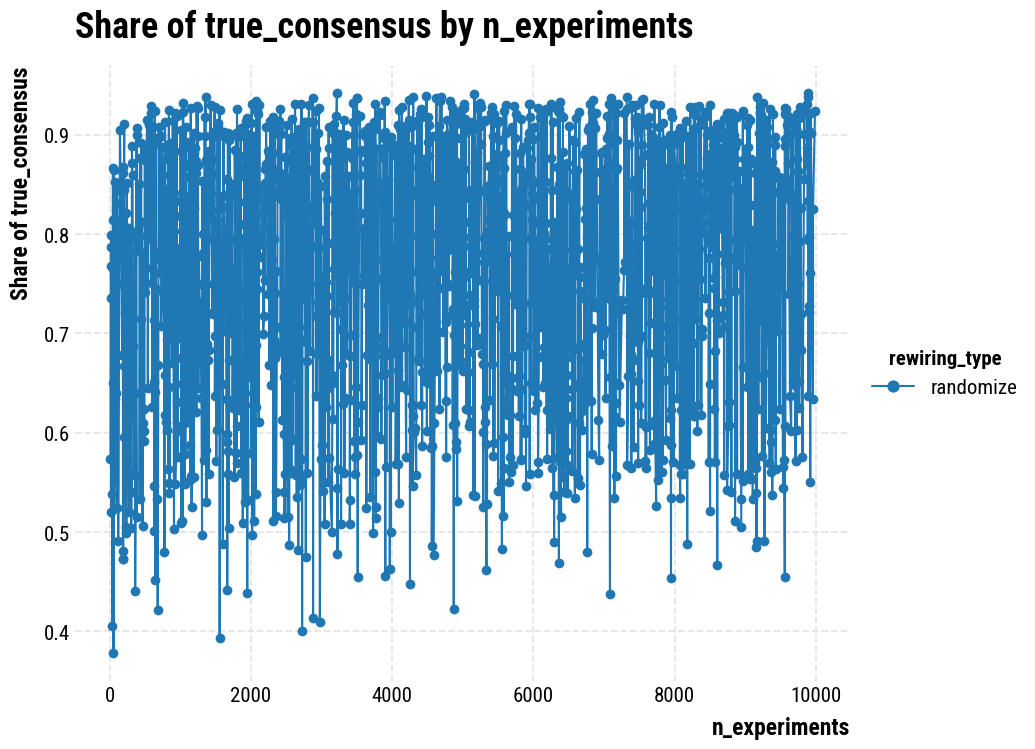

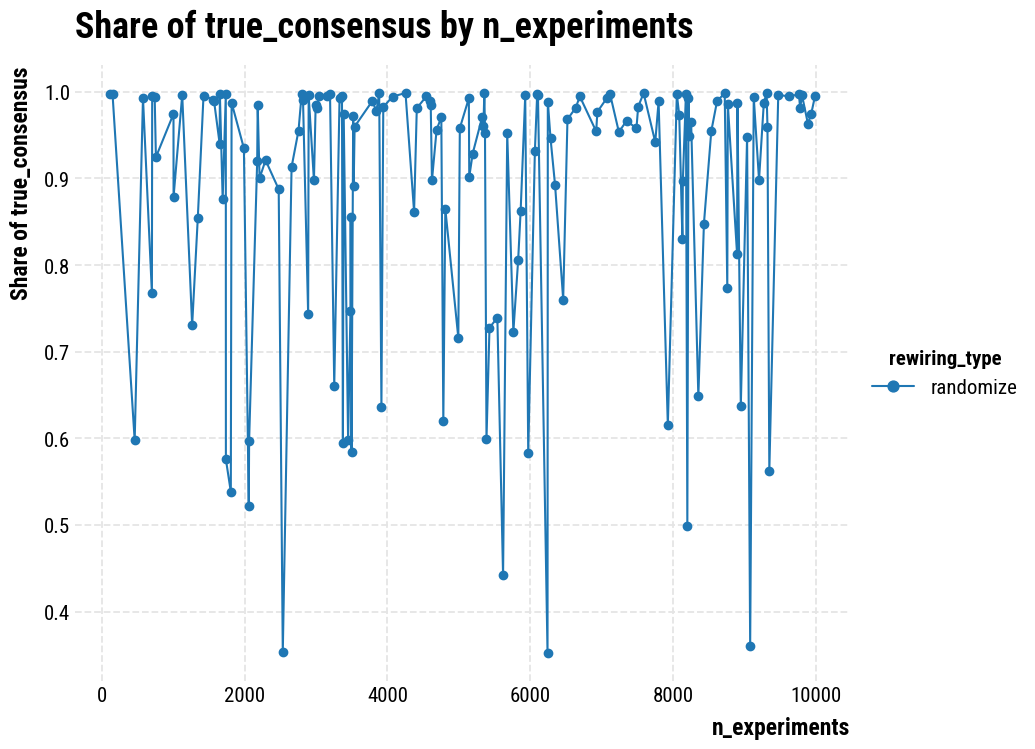

In [69]:
plot_results(bayes_results_df,variable_of_interest = 'true_consensus',regressor = 'n_experiments')
#plot_results(bayes_results_df,variable_of_interest = 'convergence_step',regressor = 'p_rewiring')
plot_results(beta_results_df,variable_of_interest = 'true_consensus',regressor = 'n_experiments')
#plot_results(beta_results_df,variable_of_interest = 'convergence_step',regressor = 'p_rewiring')

# Try Density Rewiring

## Setup

In [8]:
# initializing list
G = nx.erdos_renyi_graph(3, 0.25)
test_set = set(G.nodes)
set(itertools.product(test_set,test_set))


{(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)}

In [11]:
def generate_parameters_empir_v2(n,G,rewiring_type='density',valence=False):
    actual_edges = set(G.edges()).copy()
    if valence==True:
        print('Computing all new potential edges in parameter generation...')
        #all_possible_edges = set(nx.complete_graph(G.nodes).edges())
        all_possible_edges = set(itertools.product(set(G.nodes).copy(), set(G.nodes).copy()))
        # Get all possible edges for the complete graph with the same nodes
        #all_possible_edges = set(nx.complete_graph(G.nodes).edges())
        all_new_potential_edges = all_possible_edges - actual_edges
        # Remove pairs where both elements are the same
        identical_pairs = {(num, num) for num in actual_edges}
        all_new_potential_edges = all_new_potential_edges - identical_pairs
        print('found all new potential edges')
    else:
        all_new_potential_edges = set()
    params_list = []
    #print('Generating parameters...')
    for _ in tqdm(range(n),desc="Generating parameters"):
        #n_agents = random.randint(10, 500)
        n_agents = len(G.nodes())
        #ba_degree = random.randint(1, int(n_agents/10))
        #er_prob=random.uniform(0, 0.3)
        p_rewiring = random.uniform(0, 1)
        #print(p_rewiring)
        if rewiring_type=='density':
            #G_er = nx.gnp_random_graph(n_agents, er_prob, directed=True)
            #print('densifying...')
            network = densify_network(G, p_densify=p_rewiring,valence=valence,actual_edges=actual_edges,
                                      all_new_potential_edges=all_new_potential_edges)
        # Calculate the mean degree of each node
        degrees = dict(network.degree())
        mean_degree = sum(degrees.values()) / len(degrees)
        uncertainty = random.uniform(0.001,0.025)
        n_experiments = random.randint(10, 10000)
        params = {
            "n_agents": n_agents,
            #"ba_degree": ba_degree,
            #"er_prob":er_prob,
            "p_rewiring": p_rewiring,
            'densify_valence':valence,
            "rewiring_type":rewiring_type,
            "network": network,
            "uncertainty": uncertainty,
            "n_experiments": n_experiments,
            'mean_degree':mean_degree
        }
        params_list.append(params)
    return params_list

In [12]:
%%time
# Example usage
# G_pepticulcer_indexed
# G_perceptron_indexed
parameter_dictionaries = generate_parameters_empir_v2(2,G_perceptron_indexed,
                                                      rewiring_type='density',valence=True)  # Generate parameter dictionaries
parameter_dictionaries

Computing all new potential edges in parameter generation...
found all new potential edges


Generating parameters: 100%|██████████| 2/2 [00:58<00:00, 29.38s/it]


CPU times: user 1min 2s, sys: 2.86 s, total: 1min 4s
Wall time: 1min 12s


[{'n_agents': 3519,
  'p_rewiring': 0.3618005480408798,
  'densify_valence': True,
  'rewiring_type': 'density',
  'network': <networkx.classes.digraph.DiGraph at 0x7fb7d6ffb0a0>,
  'uncertainty': 0.007201764051557633,
  'n_experiments': 7505,
  'mean_degree': 2549.125888036374},
 {'n_agents': 3519,
  'p_rewiring': 0.986594745036754,
  'densify_valence': True,
  'rewiring_type': 'density',
  'network': <networkx.classes.digraph.DiGraph at 0x7fb7da375690>,
  'uncertainty': 0.024523831646978255,
  'n_experiments': 5637,
  'mean_degree': 6943.711849957374}]

In [13]:
%%time
# Test Simulation
parameter_dictionaries = generate_parameters_empir_v2(2,G_pepticulcer_indexed,
                                                      rewiring_type='density',valence=False) # Generate parameter dictionaries
#print(parameter_dictionaries)
test_results_densify_df = run_simulations(parameter_dictionaries, number_of_steps=10000, 
                                  agent_type="bayes",tolerance=1e-02)
test_results_densify_df.to_csv('test_results_densify_df.csv', index=False)
test_results_densify_df.head()

Running simulations: 100%|██████████| 2/2 [01:35<00:00, 47.96s/it]

CPU times: user 1min 44s, sys: 1.04 s, total: 1min 45s
Wall time: 1min 51s


,n_agents,p_rewiring,densify_valence,rewiring_type,uncertainty,n_experiments,mean_degree,true_consensus,convergence_step,agent_type
0,133403,0.891784,False,density,0.016593,963,1.273704,0.517545,19,bayes
1,133403,0.424055,False,density,0.003428,4619,6.781107,0.490251,74,bayes


## Perceptron

In [16]:
%%time
print(datetime.now())
# Bayes Agent
do_initial_simulation = False
if do_initial_simulation:
    n_sims = 10 # this is for each type of rewiring
    bayes_results_df = pd.DataFrame(columns=test_results_densify_df.columns)
    # First with False valence
    parameter_dictionaries = generate_parameters_empir_v2(n_sims,G_perceptron_indexed,
                                                    rewiring_type='density',valence=False)
    results_df1 = run_simulations(parameter_dictionaries, number_of_steps=10000, 
                                agent_type="bayes",tolerance=1e-03)
    bayes_results_df = pd.concat([bayes_results_df, results_df1], ignore_index=True)
    # Then with True valence
    parameter_dictionaries = generate_parameters_empir_v2(n_sims,G_perceptron_indexed,
                                                    rewiring_type='density',valence=True)
    results_df2 = run_simulations(parameter_dictionaries, number_of_steps=10000, 
                                agent_type="bayes",tolerance=1e-03)
    bayes_results_df = pd.concat([bayes_results_df, results_df2], ignore_index=True)
    bayes_results_df.to_csv('bayesagent_perceptron_results_densify_df.csv', index=False)

saved_bayes_results_df = pd.read_csv('bayesagent_perceptron_results_densify_df.csv')

add_simulations = True
if add_simulations:
    n_sims = 90 # this is for each type of rewiring
    bayes_results_df = pd.DataFrame(columns=test_results_densify_df.columns)
    # First with False valence
    parameter_dictionaries = generate_parameters_empir_v2(n_sims,G_perceptron_indexed,
                                                    rewiring_type='density',valence=False)
    results_df1 = run_simulations(parameter_dictionaries, number_of_steps=10000, 
                                agent_type="bayes",tolerance=1e-03)
    bayes_results_df = pd.concat([bayes_results_df, results_df1], ignore_index=True)
    # Then with True valence
    parameter_dictionaries = generate_parameters_empir_v2(n_sims,G_perceptron_indexed,
                                                    rewiring_type='density',valence=True)
    results_df2 = run_simulations(parameter_dictionaries, number_of_steps=10000, 
                                agent_type="bayes",tolerance=1e-03)
    bayes_results_df = pd.concat([bayes_results_df, results_df2], ignore_index=True)
    bayes_results_df = pd.concat([saved_bayes_results_df, bayes_results_df], ignore_index=True)
    bayes_results_df.to_csv('bayesagent_perceptron_results_densify_df.csv', index=False)
else: 
    bayes_results_df=saved_bayes_results_df

print(datetime.now())
    
bayes_results_df.info()

Running simulations: 100%|██████████| 90/90 [01:54<00:00,  1.27s/it]


Computing all new potential edges in parameter generation...
found all new potential edges


Running simulations: 100%|██████████| 90/90 [1:04:29<00:00, 43.00s/it]   


2024-07-13 13:43:59.849220
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   n_agents          200 non-null    object 
 1   p_rewiring        200 non-null    float64
 2   densify_valence   200 non-null    object 
 3   rewiring_type     200 non-null    object 
 4   uncertainty       200 non-null    float64
 5   n_experiments     200 non-null    object 
 6   mean_degree       200 non-null    float64
 7   true_consensus    200 non-null    float64
 8   convergence_step  200 non-null    object 
 9   agent_type        200 non-null    object 
dtypes: float64(4), object(6)
memory usage: 15.8+ KB


In [17]:
%%time
print(datetime.now())
# Beta Agent
do_initial_simulation = False
if do_initial_simulation:
    n_sims = 5 # this is for each type of rewiring
    beta_results_df = pd.DataFrame(columns=test_results_densify_df.columns)
    # First with False valence
    parameter_dictionaries = generate_parameters_empir_v2(n_sims,G_perceptron_indexed,
                                                    rewiring_type='density',valence=False)
    results_df1 = run_simulations(parameter_dictionaries, number_of_steps=10000, 
                                agent_type="beta",tolerance=1e-03)
    beta_results_df = pd.concat([beta_results_df, results_df1], ignore_index=True)
    # Then with True valence
    parameter_dictionaries = generate_parameters_empir_v2(n_sims,G_perceptron_indexed,
                                                    rewiring_type='density',valence=True)
    results_df2 = run_simulations(parameter_dictionaries, number_of_steps=10000, 
                                agent_type="beta",tolerance=1e-03)
    beta_results_df = pd.concat([beta_results_df, results_df2], ignore_index=True)
    beta_results_df.to_csv('betaagent_perceptron_results_densify_df.csv', index=False)

saved_beta_results_df = pd.read_csv('betaagent_perceptron_results_densify_df.csv')

add_simulations = True
if add_simulations:
    n_sims = 45 # this is for each type of rewiring
    beta_results_df = pd.DataFrame(columns=test_results_densify_df.columns)
    # First with False valence
    parameter_dictionaries = generate_parameters_empir_v2(n_sims,G_perceptron_indexed,
                                                    rewiring_type='density',valence=False)
    results_df1 = run_simulations(parameter_dictionaries, number_of_steps=10000, 
                                agent_type="beta",tolerance=1e-03)
    beta_results_df = pd.concat([beta_results_df, results_df1], ignore_index=True)
    # Then with True valence
    parameter_dictionaries = generate_parameters_empir_v2(n_sims,G_perceptron_indexed,
                                                    rewiring_type='density',valence=True)
    results_df2 = run_simulations(parameter_dictionaries, number_of_steps=10000, 
                                agent_type="beta",tolerance=1e-03)
    beta_results_df = pd.concat([beta_results_df, results_df2], ignore_index=True)
    beta_results_df = pd.concat([saved_beta_results_df, beta_results_df], ignore_index=True)
    beta_results_df.to_csv('betaagent_perceptron_results_densify_df.csv', index=False)
else: 
    beta_results_df=saved_beta_results_df

print(datetime.now())
    
beta_results_df.info()

Running simulations:  82%|████████▏ | 37/45 [05:15<01:03,  7.99s/it]

## Peptic Ulcer

In [ ]:
%%time
print(datetime.now())
# Bayes Agent
do_initial_simulation = True
if do_initial_simulation:
    n_sims = 1 # this is for each type of rewiring
    bayes_results_df = pd.DataFrame(columns=test_results_densify_df.columns)
    # First with False valence
    parameter_dictionaries = generate_parameters_empir_v2(n_sims,G_pepticulcer_indexed,
                                                    rewiring_type='density',valence=False)
    results_df1 = run_simulations(parameter_dictionaries, number_of_steps=10000, 
                                agent_type="bayes",tolerance=1e-03)
    bayes_results_df = pd.concat([bayes_results_df, results_df1], ignore_index=True)
    # Then with True valence
    parameter_dictionaries = generate_parameters_empir_v2(n_sims,G_pepticulcer_indexed,
                                                    rewiring_type='density',valence=True)
    results_df2 = run_simulations(parameter_dictionaries, number_of_steps=10000, 
                                agent_type="bayes",tolerance=1e-03)
    bayes_results_df = pd.concat([bayes_results_df, results_df2], ignore_index=True)
    bayes_results_df.to_csv('bayesagent_pepticulcer_results_densify_df.csv', index=False)

saved_bayes_results_df = pd.read_csv('bayesagent_pepticulcer_results_densify_df.csv')

add_simulations = False
if add_simulations:
    n_sims = 1500 # this is for each type of rewiring
    bayes_results_df = pd.DataFrame(columns=test_results_densify_df.columns)
    # First with False valence
    parameter_dictionaries = generate_parameters_empir_v2(n_sims,G_pepticulcer_indexed,
                                                    rewiring_type='density',valence=False)
    results_df1 = run_simulations(parameter_dictionaries, number_of_steps=10000, 
                                agent_type="bayes",tolerance=1e-03)
    bayes_results_df = pd.concat([bayes_results_df, results_df1], ignore_index=True)
    # Then with True valence
    parameter_dictionaries = generate_parameters_empir_v2(n_sims,G_pepticulcer_indexed,
                                                    rewiring_type='density',valence=True)
    results_df2 = run_simulations(parameter_dictionaries, number_of_steps=10000, 
                                agent_type="bayes",tolerance=1e-03)
    bayes_results_df = pd.concat([bayes_results_df, results_df2], ignore_index=True)
    bayes_results_df = pd.concat([saved_bayes_results_df, bayes_results_df], ignore_index=True)
    bayes_results_df.to_csv('bayesagent_pepticulcer_results_densify_df.csv', index=False)
else: 
    bayes_results_df=saved_bayes_results_df

print(datetime.now())
    
bayes_results_df.info()

In [ ]:
%%time
print(datetime.now())
# Beta Agent
do_initial_simulation = True
if do_initial_simulation:
    n_sims = 1 # this is for each type of rewiring
    beta_results_df = pd.DataFrame(columns=test_results_densify_df.columns)
    # First with False valence
    parameter_dictionaries = generate_parameters_empir_v2(n_sims,G_pepticulcer_indexed,
                                                    rewiring_type='density',valence=False)
    results_df1 = run_simulations(parameter_dictionaries, number_of_steps=10000, 
                                agent_type="beta",tolerance=1e-03)
    beta_results_df = pd.concat([beta_results_df, results_df1], ignore_index=True)
    # Then with True valence
    parameter_dictionaries = generate_parameters_empir_v2(n_sims,G_pepticulcer_indexed,
                                                    rewiring_type='density',valence=True)
    results_df2 = run_simulations(parameter_dictionaries, number_of_steps=10000, 
                                agent_type="beta",tolerance=1e-03)
    beta_results_df = pd.concat([beta_results_df, results_df2], ignore_index=True)
    beta_results_df.to_csv('betaagent_pepticulcer_results_densify_df.csv', index=False)

saved_beta_results_df = pd.read_csv('betaagent_pepticulcer_results_densify_df.csv')

add_simulations = False
if add_simulations:
    n_sims = 1500 # this is for each type of rewiring
    beta_results_df = pd.DataFrame(columns=test_results_densify_df.columns)
    # First with False valence
    parameter_dictionaries = generate_parameters_empir_v2(n_sims,G_pepticulcer_indexed,
                                                    rewiring_type='density',valence=False)
    results_df1 = run_simulations(parameter_dictionaries, number_of_steps=10000, 
                                agent_type="beta",tolerance=1e-03)
    beta_results_df = pd.concat([beta_results_df, results_df1], ignore_index=True)
    # Then with True valence
    parameter_dictionaries = generate_parameters_empir_v2(n_sims,G_pepticulcer_indexed,
                                                    rewiring_type='density',valence=True)
    results_df2 = run_simulations(parameter_dictionaries, number_of_steps=10000, 
                                agent_type="beta",tolerance=1e-03)
    beta_results_df = pd.concat([beta_results_df, results_df2], ignore_index=True)
    beta_results_df = pd.concat([saved_beta_results_df, beta_results_df], ignore_index=True)
    beta_results_df.to_csv('betaagent_pepticulcer_results_densify_df.csv', index=False)
else: 
    beta_results_df=saved_beta_results_df

print(datetime.now())
    
bayes_results_df.info()